# Tweets and Flair

This is an analysis using twitter data scraped during the coronavirus, and will be taking a look at how the tweets in the US changed over time.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

FIN = 'data/flair_joined_tweets.csv'

raw = pd.read_csv(FIN)

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

# changing na to None
raw = raw.fillna('None')

raw.head()

,created_at,place,text,pos,ner,sentiment,date,time,hour
0,2020-02-10 07:03:44+00:00,"Paradise, NV",Having a mocha and avoiding coronavirus at the...,"[['Having', 'VBG'], ['a', 'DT'], ['mocha', 'NN...",None,POSITIVE,2020-02-10,07:03:44,7
1,2020-02-10 07:04:49+00:00,"Queens, NY",@LinSapna Our hearts ❤️ beat with China 🇨🇳,"[['@LinSapna', 'NNP'], ['Our', 'PRP$'], ['hear...",['China'],POSITIVE,2020-02-10,07:04:49,7
2,2020-02-10 07:05:30+00:00,"Tempe, AZ",people stop my sister in the street to make fu...,"[['people', 'NNS'], ['stop', 'VBP'], ['my', 'P...",None,POSITIVE,2020-02-10,07:05:30,7
3,2020-02-10 07:07:14+00:00,"Oceanside, CA",@PoliticalAvengr @lookner @The_Dex_J @Marfoogl...,"[['@PoliticalAvengr', 'ADD'], ['@lookner', 'AD...",None,NEGATIVE,2020-02-10,07:07:14,7
4,2020-02-10 07:09:05+00:00,"Miami, FL","Desafortunadamente, el fútbol chino se unió a ...","[['Desafortunadamente,', 'FW'], ['el', 'FW'], ...","['Zhejiang', 'Bengbu, provincia de Anhui. Vía ...",NEGATIVE,2020-02-10,07:09:05,7


Here is the head of the data, as we can see the part of speech includes each word and POS tag from flair. Also, not every tweet has a named entity. The date, time, and hour of the tweet posted are also seperated from the 'created_at' column.

## Info on data

Lets try and get a feel for what all this data includes.

In [3]:
print('Shape of data:', raw.shape)
print('# of Unique places:',len(raw['place'].unique()))
print('first recorded tweet:', raw['date'].min())
print('last recorded tweet:', raw['date'].max())

Shape of data: (153153, 9)
# of Unique places: 9428
first recorded tweet: 2020-01-22
last recorded tweet: 2020-03-21


Lets dive in:

* As we can see there are ~153k tweets over the course of 2 months, all from the United States of America.
* The tweets start on Janurary 22, 2020 and end on March 21, 2020.
* There are a total of 9428 unique places which means this data is messy and will take some creativity to clean up.

## Graphing

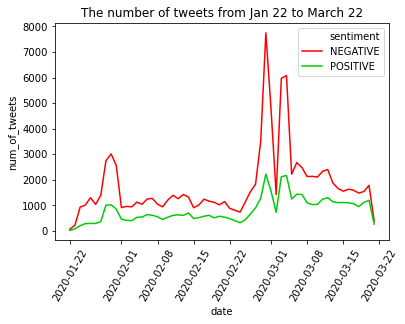

In [4]:
# getting counts for each date -> sentiment
plot_data = raw.groupby(['date', 'sentiment']).count()['text'].reset_index()
# rename
plot_data.columns = ['date', 'sentiment', 'num_of_tweets']

# plotting
plot = sns.lineplot(data= plot_data, x= 'date', y="num_of_tweets", hue= 'sentiment', palette= ['#ff0000', '#00cc00'])
plot = plot.set_title("The number of tweets from Jan 22 to March 22")
plot = plt.xticks(rotation=60)


Here we can see the number of tweets for each day that is gathered. There are some obvious spikes, however overall there are much more negative tweets than positive ones. One thing to note is the two sentiments seem to roughly follow the same pattern, however the negative tweets tend to spike much higher.

Lets see if we can figure out more on this.

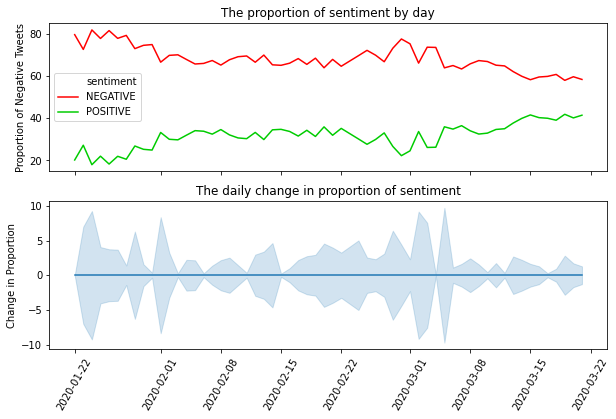

In [5]:
# getting sum of date -> sentiment
date_sent = plot_data.groupby(['date', 'sentiment']).agg({'num_of_tweets':'sum'})
# getting sum of dates
date = plot_data.groupby('date').agg({'num_of_tweets':'sum'})
# making proportion
prop_data = date_sent.div(date, level= 'date') * 100
# finding differences in proportion
prop_data['diffs'] = prop_data.groupby(['sentiment'])['num_of_tweets'].transform(lambda x: x.diff())
prop_data = prop_data.reset_index()
# fill NaN value
prop_data['diffs'] = prop_data['diffs'].fillna(0)


# plotting
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex= True)

p1 = sns.lineplot(data= prop_data, x= 'date', y="num_of_tweets", palette= ['#ff0000', '#00cc00'], hue= 'sentiment', ax= ax[0]).set_title("The proportion of sentiment by day")
ax[0].set(ylabel='Proportion of Negative Tweets')

sns.lineplot(data= prop_data, x= 'date', y="diffs", ax= ax[1]).set_title("The daily change in proportion of sentiment")
ax[1].set(ylabel='Change in Proportion')

plot = plt.xlabel("")
plot = plt.xticks(rotation=60)

This plot describes the daily change in the daily proportion of negative tweets.

$prop(day)=\frac{negative}{negative+positive}*100$

$change=prop(day_0)-prop(day_1)$

The first graph shows the proportion of sentiment each day, getting closer to 50% overtime.

The second graph shows the daily changes in proportion, or how volatile the tweets are. With the biggest change nearing 10%.


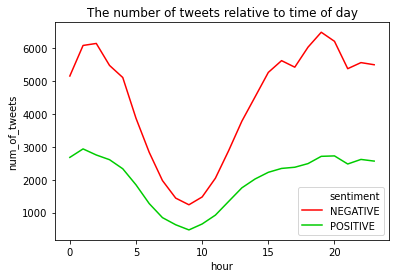

In [6]:
# getting coutns for hour -> sentiment
plot_data = raw.groupby(['hour', 'sentiment']).count()['text'].reset_index()
# renaming
plot_data.columns = ['hour', 'sentiment', 'num_of_tweets']

# plotting
plot = sns.lineplot(data= plot_data, x= 'hour', y="num_of_tweets", hue= 'sentiment', palette= ['#ff0000', '#00cc00'])
plot = plot.set_title("The number of tweets relative to time of day")

Here we can see the number of tweets depending on the time of day. This is based on the 24-hour clock, so hour 19 would be 7 pm.

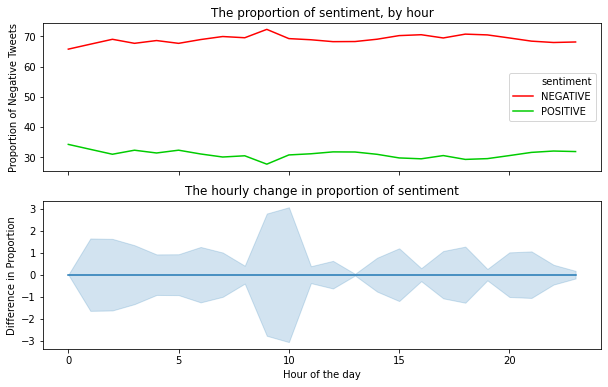

In [22]:
# getting sum of hour -> sentiment
hour_sent = plot_data.groupby(['hour', 'sentiment']).agg({'num_of_tweets':'sum'})
# getting sum of hour
hour = plot_data.groupby('hour').agg({'num_of_tweets':'sum'})
# making proportion
prop_data = hour_sent.div(hour, level= 'hour') * 100
# finding difference in proportion
prop_data['diffs'] = prop_data.groupby(['sentiment'])['num_of_tweets'].transform(lambda x: x.diff())
prop_data = prop_data.reset_index()
# fill NaN value
prop_data['diffs'] = prop_data['diffs'].fillna(0)

# plotting
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex= True)

p1 = sns.lineplot(data= prop_data, x= 'hour', y="num_of_tweets", palette= ['#ff0000', '#00cc00'], hue= 'sentiment', ax= ax[0]).set_title("The proportion of sentiment, by hour")
ax[0].set(ylabel='Proportion of Negative Tweets')

sns.lineplot(data= prop_data, x= 'hour', y="diffs", ax= ax[1]).set_title("The hourly change in proportion of sentiment")
ax[1].set(ylabel='Difference in Proportion')
plot = plt.xlabel("Hour of the day")

This is the same type of plot as last time.

$prop(day)=\frac{negative}{negative+positive}*100$

$change=prop(day_0)-prop(day_1)$

The first graph shows the proportion of sentiment each day, which seems to be relatively stable throughout the day.

The second graph shows the daily changes in proportion, or how volatile the tweets are. The highest change being a 3% difference in sentiment.

This leads to show that the overall sentiment does not change much throughout each individual day, however throughout the time recorded the sentiment has started to get closer torwards an even amount of negative and positive sentiment.



time is in universal timezone, will need to be changed!!


Barchart of verbs and ner. wordcloud?? adjectives?


anything in particular, trump sentiment? china sentiment? masks? ect.


get states and cities, barchart top states, sentiment by state?


get dates for major reform? correlation to number of tests, number of cases, deaths?


scrape more tweets?
